In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
%%capture
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [14]:
%%capture
!pip -q install textblob

# 데이터 통합

In [1]:
import pandas as pd

# 파일 경로 및 정보
files = {
    "Nami Island": "gangwon_namiIsland.csv",
    "Seoraksan": "gangwon_mt.csv",
    "Bulguksa": "bulguksa.csv",
    "Hahoe Village": "andong_village.csv",
    "Andong Museum" : "andong_museum.csv",
    "Gyeongju Museum" : "gyeongju_museum.csv"
}

place_type = {
    "Nami Island": "traditional",
    "Seoraksan": "traditional",
    "Bulguksa": "history",
    "Hahoe Village": "history",
    "Andong Museum" : "museum",
    "Gyeongju Museum" : "museum"
}

encodings_to_try = ["utf-8", "cp949", "ISO-8859-1", "utf-16"]
columns = ["review"]

df_list = []

for place, path in files.items():
    for enc in encodings_to_try:
        try:
            df = pd.read_csv(path, encoding=enc, header=None)
            df = df.rename(columns={0: "review"})
            df["place"] = place
            df["type"] = place_type[place]
            df_list.append(df)
            print(f"{place} loaded successfully with encoding: {enc}")
            break
        except:
            continue

df_combined = pd.concat(df_list, ignore_index=True)


Nami Island loaded successfully with encoding: utf-8
Seoraksan loaded successfully with encoding: ISO-8859-1
Bulguksa loaded successfully with encoding: utf-8
Hahoe Village loaded successfully with encoding: utf-8
Andong Museum loaded successfully with encoding: utf-8
Gyeongju Museum loaded successfully with encoding: utf-8


In [2]:
df_combined.head()

,review,place,type
0,review,Nami Island,traditional
1,최근순가장 최근의 게시 날짜를 기준으로 내림차순으로 정렬된 리뷰.상세 리뷰:대기 시...,Nami Island,traditional
2,One Must Go!,Nami Island,traditional
3,If in Seoul one must go. Very romantic and ext...,Nami Island,traditional
4,From Seoul to Serenity: A Day on Nami Island N...,Nami Island,traditional


In [ ]:
df_combined.info()

In [ ]:
df_combined['place'].unique()

In [ ]:
df_combined[df_combined['place'] == 'Seoraksan'].head()

In [ ]:
df_combined[df_combined['place'] == 'Bulguksa'].head()

In [3]:
# 시스템 문구 포함된 리뷰 제거
df_combined = df_combined[~df_combined["review"].str.contains(
    "Most Recent:Reviews ordered by most recent publish date",
    case=False,
    na=False
)]

# 2. 첫 번째 행에 'review' 텍스트가 들어간 경우 제거
df_combined = df_combined[df_combined["review"] != "review"]

# 3. 결측치(NaN) 및 공백("") 리뷰 제거
df_combined = df_combined[df_combined["review"].notna()]  # NaN 제거
df_combined = df_combined[df_combined["review"].str.strip() != ""]  # 빈 문자열 제거

# 4. 인덱스 초기화
df_combined.reset_index(drop=True, inplace=True)


In [4]:
df_combined['review'].tail()

,review
1525,This is a great museum. It's small enough to g...
1526,When travelling around South Korea there are m...
1527,I had a beautiful afternoon in Gyeongju gettin...
1528,Excellent museum with lots of fascinating exhi...
1529,Gyeongju has an incredible past. This museum c...


In [ ]:
df_combined.info()

# 텍스트 전처리 최종

In [5]:
import nltk
# nltk 리소스 (처음 1번만 실행)
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

- NLTK 리소스(wordnet, omw, POS 태거) 준비

In [6]:
# NLTK (레마타이저 + POS 태깅)

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

# (최초 1회만 필요) 리소스 준비
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4')
# 태거는 배포에 따라 이름이 다를 수 있어 둘 다 시도
for res in ['taggers/averaged_perceptron_tagger', 'taggers/averaged_perceptron_tagger_eng']:
    try:
        nltk.data.find(res)
        break
    except LookupError:
        try:
            nltk.download(res.split('/')[-1])
        except:
            pass

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


### 감성 점수 (원문 기준, 먼저 계산)

- **원문 리뷰 텍스트**를 문장 단위로 분리
- 각 문장에 대해 `TextBlob`을 이용해 polarity(감성 점수) 계산
- 리뷰 단위에서는 문장 점수의 평균을 사용
- `df_combined["sentiment_score"]`, `df_combined["sentiment_label"]` 생성
  - 점수가 0.1 이상 → positive
  - 점수가 -0.1 이하 → negative
  - 그 외 → neutral

In [7]:
import re, unicodedata, html
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# 감성 점수용
from textblob import TextBlob

# 문장 분리 (원문 기준)
def split_sentences_for_sentiment(text: str):
    if not isinstance(text, str):
        return []
    parts = re.split(r"[\.!?…]+|\n+", text)
    return [p.strip() for p in parts if p and p.strip()]

# 문장별 polarity
def sentence_polarity(s: str) -> float:
    try:
        return TextBlob(s).sentiment.polarity
    except Exception:
        return 0.0

# 리뷰 단위 점수 집계 (평균)
def review_sentiment_score(review: str) -> float:
    sents = split_sentences_for_sentiment(review)
    if not sents:
        return 0.0
    scores = [sentence_polarity(s) for s in sents]
    return float(np.mean(scores))

# 적용
df_combined["sentiment_score"] = df_combined["review"].apply(review_sentiment_score)

# 라벨
def label_sentiment(score: float) -> str:
    if score > 0.1:  return "positive"
    if score < -0.1: return "negative"
    return "neutral"

df_combined["sentiment_label"] = df_combined["sentiment_score"].apply(label_sentiment)

print(df_combined[["sentiment_score","sentiment_label"]].head())

   sentiment_score sentiment_label
0         0.000000         neutral
1         0.000000         neutral
2         0.280926        positive
3         0.365625        positive
4         0.250000        positive


### 불용어 세팅 & 전처리 유틸 (Lemmatization)

- **불용어 집합**:
  - `ENGLISH_STOP_WORDS`(기본)  
  - 도메인 중립어 (여행 리뷰에서 너무 일반적인 단어들: place, trip, people 등)  
  - 보편 긍정 감탄사 (beautiful, great, nice 등)  
- **토큰화 처리 과정**:
  1. 텍스트 정규화 (소문자, URL/HTML 제거, 축약형 처리 등)
  2. 토큰화 (알파벳/숫자 조합)
  3. 불용어/짧은 토큰 제거
  4. Lemmatization 적용 → ex)`visited/visiting` → `visit`, `temples` → `temple`


In [8]:
# 불용어 (기본 + 도메인 일반어 + 보편 긍정어)
STOPWORDS_BASE = set(ENGLISH_STOP_WORDS)
DOMAIN_NEUTRAL = {
    "really","very","quite","maybe","also","just","bit","lot","thing","stuff",
    "place","spot","area","location","site","attraction","viewpoint","facility","facilities",
    "experience","experiences","trip","journey","tour","tourist",
    "people","person","someone","anyone","everyone","everything",
    "many","much","more","most","less","least","few","several","various","etc",
    "korea","korean","south","north","city","town","village","center","station",
    "park","mountain","island","seoraksan","bulguksa","hahoe","andong","museum","gyeongju",
}
COMMON_TRAVEL_POS = {"beautiful","great","nice","amazing","awesome","wonderful","perfect","best","good"}

STOPWORDS_EN = STOPWORDS_BASE.union(DOMAIN_NEUTRAL)
STOPWORDS_TOKENS = STOPWORDS_EN.union(COMMON_TRAVEL_POS)

# 옵션
USE_LEMMATIZATION = True
_lemmatizer = WordNetLemmatizer()

# 정규화/토큰화 유틸
CONTRACTIONS = [
    (r"n't\b", " not"), (r"'re\b"," are"), (r"'m\b"," am"),
    (r"'ll\b"," will"), (r"'ve\b"," have"), (r"'d\b"," would"), (r"'s\b"," is"),
]
URL_RE  = re.compile(r"https?://\S+|www\.\S+", re.I)
HTML_RE = re.compile(r"<[^>]+>")
APOST_RE= re.compile(r"[’`´]")
TOKEN_RE= re.compile(r"[a-z][a-z0-9]+")

def normalize_english(text: str) -> str:
    s = unicodedata.normalize("NFKC", str(text)).lower()
    s = html.unescape(s)
    s = APOST_RE.sub("'", s)
    s = URL_RE.sub(" ", s)
    s = HTML_RE.sub(" ", s)
    s = s.replace("-", " ").replace("_"," ")
    for pat, rep in CONTRACTIONS:
        s = re.sub(pat, rep, s)
    return s.strip()

def tokenize_en(text: str):
    return TOKEN_RE.findall(text)

def _tb2wn_pos(tb_tag: str):
    if tb_tag.startswith('J'): return wordnet.ADJ
    if tb_tag.startswith('V'): return wordnet.VERB
    if tb_tag.startswith('N'): return wordnet.NOUN
    if tb_tag.startswith('R'): return wordnet.ADV
    return wordnet.NOUN

def lemmatize_tokens(tokens):
    if not tokens: return tokens
    tags = pos_tag(tokens)
    return [_lemmatizer.lemmatize(t, _tb2wn_pos(pos)) for t, pos in tags]

def preprocess_and_tokenize_en(sentence: str, stopwords: set = STOPWORDS_TOKENS):
    s = normalize_english(sentence)
    toks = tokenize_en(s)
    toks = [t for t in toks if t not in stopwords and len(t) > 1]
    if USE_LEMMATIZATION:
        toks = lemmatize_tokens(toks)      # 모든 단어를 원형화
    return toks

def split_sentences(text: str):
    parts = re.split(r"[\.!?…]+|\n+", str(text))
    return [p.strip() for p in parts if p and p.strip()]

### 리뷰→토큰 DF 생성 → 공통어(DF/CV) 제거

- 리뷰 데이터를 문장 단위로 나눠 토큰화 → `tokens_df` 생성
  - 각 행: (doc_id, sentence, place, type, token)
- **공통어 제거 규칙**:
  - 특정 토큰이 전체 장소의 70% 이상에서 나타남 (`df_ratio ≥ 0.7`)
  - 장소별 상대 빈도의 변동계수(CV) < 0.15 → 모든 곳에서 비슷하게 등장
    - Coefficient of Variation (CV)란?
      - 정의: 표준편차(Standard Deviation)를 평균(Mean)으로 나눈 값
      - 해석: 어떤 값이 평균 대비 얼마나 흩어져 있는지를 나타내는 상대적 분산 척도예요.
        
          값이 작다 (CV < 0.15) → 모든 장소에서 거의 같은 비율로 등장한다는 뜻 → 장소별 차별성이 없는 보편 단어.
          : 단어가 장소별로 비슷한 비율로 등장해서, 차별적인 의미를 주지 못한다”라는 이유로 제거

값이 크다 → 어떤 장소에서는 많이, 다른 장소에서는 적게 등장 → 장소별 특성을 반영하는 단어.
  - 최소 등장 장소 수 기준 (df_places ≥ min_df_threshold)
    - 특정 단어가 최소 장소 수 이상에서 반복적으로 등장하면 제거.
    
- 위 조건을 만족하는 토큰들을 drop
- 드롭된 토큰 목록과 이유를 `dropped_tokens_debug.csv`로 저장 (디버깅 용)

In [9]:
# 리뷰 → 토큰 DF (index를 doc_id로 사용)
def build_tokens_from_reviews(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for i, r in df.iterrows():  # i: index == doc_id
        for s in split_sentences(r["review"]):
            toks = preprocess_and_tokenize_en(s)
            for t in toks:
                rows.append({
                    "doc_id": i,
                    "sentence": s,
                    "place": r["place"],
                    "type": r["type"],
                    "token": t,
                    "weight": 1.0
                })
    return pd.DataFrame(rows)

tokens_df = build_tokens_from_reviews(df_combined)

# --- 공통어 제거(DF/CV) ---
DF_RATIO_DROP = 0.70
CV_DROP       = 0.15
MIN_DF_PLACES = 3

N_places = tokens_df["place"].nunique()
if N_places == 0:
    raise ValueError("N_places=0: tokens_df에 place 값이 없습니다.")

dynamic_min = int(np.ceil(0.7 * N_places)) if N_places < 8 else MIN_DF_PLACES
min_df_threshold = max(MIN_DF_PLACES, dynamic_min)

# (1) df_ratio / df_places
df_places = (tokens_df.drop_duplicates(["place","token"])
                        .groupby("token")["place"].nunique()
                        .rename("df_places"))
df_ratio = (df_places / float(N_places)).rename("df_ratio")

# (2) CV of relative freq per place
pt_counts = (tokens_df.groupby(["place","token"]).size()
             .rename("cnt").reset_index())
place_totals = pt_counts.groupby("place")["cnt"].sum().rename("place_total")
pt = pt_counts.merge(place_totals, on="place", how="left")
pt["rel"] = pt["cnt"] / pt["place_total"].replace(0, np.nan)

rel_stats = pt.pivot_table(index="token", columns="place", values="rel", fill_value=0.0)
rel_mean  = rel_stats.mean(axis=1).rename("rel_mean")
rel_std   = rel_stats.std(axis=1).rename("rel_std")
cv = (rel_std / rel_mean.replace(0, np.nan)).fillna(0.0).rename("cv")

# (3) 합치고 드롭 플래그
common_df = pd.concat([df_places, df_ratio, cv], axis=1).reset_index()
common_df["drop_df_ratio"] = common_df["df_ratio"] >= DF_RATIO_DROP
common_df["drop_cv"]       = common_df["cv"] < CV_DROP
common_df["drop_min_df"]   = common_df["df_places"] >= min_df_threshold
common_df["drop_any"]      = common_df[["drop_df_ratio","drop_cv","drop_min_df"]].any(axis=1)

def _reason(row):
    reasons = []
    if row["drop_df_ratio"]: reasons.append(f"df_ratio≥{DF_RATIO_DROP:.2f}")
    if row["drop_cv"]:       reasons.append(f"cv<{CV_DROP:.2f}")
    if row["drop_min_df"]:   reasons.append(f"df_places≥{min_df_threshold}")
    return ", ".join(reasons) if reasons else ""

common_df["drop_reason"] = common_df.apply(_reason, axis=1)

# 적용
drop_tokens = set(common_df.loc[common_df["drop_any"], "token"])
tokens_df_raw = tokens_df.copy()
tokens_df = tokens_df[~tokens_df["token"].isin(drop_tokens)].reset_index(drop=True)

print(f"[FILTER] places N={N_places} (min_df_threshold={min_df_threshold})")
print(f"[FILTER] drop tokens: {len(drop_tokens):,} "
      f"(unique: {tokens_df_raw['token'].nunique()} → {tokens_df['token'].nunique()})")

# 디버그 저장
debug_df = (common_df[common_df["drop_any"]]
            .sort_values(by=["df_ratio","cv","df_places"], ascending=[False, True, False])
            [["token","df_places","df_ratio","cv","drop_reason"]])

print("\n[DROPPED TOKENS - TOP 30]")
print(debug_df.head(30).to_string(index=False))

try:
    debug_df.to_csv("dropped_tokens_debug.csv", index=False)
    print("\n[Saved] dropped_tokens_debug.csv")
except Exception as e:
    print(f"[WARN] CSV 저장 실패: {e}")

[FILTER] places N=6 (min_df_threshold=5)
[FILTER] drop tokens: 488 (unique: 5153 → 4665)

[DROPPED TOKENS - TOP 30]
        token  df_places  df_ratio       cv                         drop_reason
         make          6       1.0 0.132455 df_ratio≥0.70, cv<0.15, df_places≥5
         hour          6       1.0 0.150133          df_ratio≥0.70, df_places≥5
    recommend          6       1.0 0.161940          df_ratio≥0.70, df_places≥5
         time          6       1.0 0.179857          df_ratio≥0.70, df_places≥5
       minute          6       1.0 0.205041          df_ratio≥0.70, df_places≥5
        enjoy          6       1.0 0.225235          df_ratio≥0.70, df_places≥5
        spend          6       1.0 0.229733          df_ratio≥0.70, df_places≥5
           do          6       1.0 0.230200          df_ratio≥0.70, df_places≥5
          big          6       1.0 0.234283          df_ratio≥0.70, df_places≥5
       highly          6       1.0 0.239655          df_ratio≥0.70, df_places≥5
    

### tokens / cleaned_review 생성 (네트워크 코드 연결용)

- `tokens_df`를 리뷰 단위(`doc_id`)로 그룹화 → 리뷰별 고유 토큰 리스트 생성
- `df_combined`에 `tokens` 컬럼 병합
- 리스트 형태(`tokens`)를 사람이 보기 좋은 문자열(`cleaned_review`)로도 저장
- 최종적으로 `df_combined`에는:
  - `review`, `place`, `type` (원본 정보)
  - `sentiment_score`, `sentiment_label` (감성 점수)
  - `tokens` (토큰 리스트)
  - `cleaned_review` (문자열 버전)

In [10]:
# 0) df_combined 인덱스 정리(안전)
df_combined = df_combined.reset_index(drop=True)

# 1) 리뷰별 고유 토큰 리스트 → Series (index=doc_id)
doc_tokens = (tokens_df.groupby("doc_id")["token"]
              .apply(lambda s: sorted(set(s)))
              .rename("tokens"))

# 2) 인덱스 기준으로 조인(컬럼 충돌 없음)
df_combined = df_combined.join(doc_tokens)

# 3) 리스트 아닌 값은 빈 리스트로
df_combined["tokens"] = df_combined["tokens"].apply(lambda x: x if isinstance(x, list) else [])

# 4) 보기용 문자열 버전
df_combined["cleaned_review"] = df_combined["tokens"].apply(
    lambda toks: " ".join(toks) if isinstance(toks, list) else ""
)

print("\n[INFO] tokens rows:", len(tokens_df), "unique tokens:", tokens_df["token"].nunique())
print("[CHECK] df_combined cols:",
      [c for c in df_combined.columns if c in ("tokens","cleaned_review","sentiment_score","sentiment_label","place","type")])


[INFO] tokens rows: 19125 unique tokens: 4665
[CHECK] df_combined cols: ['place', 'type', 'sentiment_score', 'sentiment_label', 'tokens', 'cleaned_review']


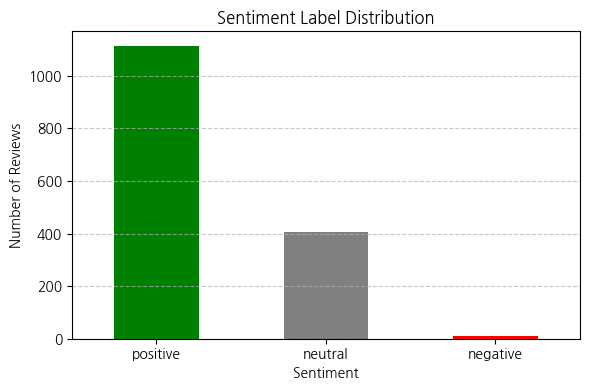

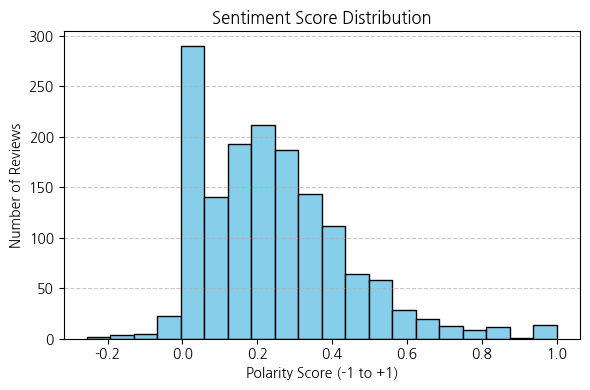

In [15]:
# 1. 감성 라벨 분포 (막대그래프)
label_counts = df_combined["sentiment_label"].value_counts()

plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title("Sentiment Label Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. 감성 점수 분포 (히스토그램)
plt.figure(figsize=(6, 4))
plt.hist(df_combined["sentiment_score"], bins=20, color='skyblue', edgecolor='black')
plt.title("Sentiment Score Distribution")
plt.xlabel("Polarity Score (-1 to +1)")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- positive 리뷰가 전체의 약 75% 이상으로 압도적 다수
- neutral 리뷰는 약 25%, negative는 극소수

극단성이 낮고, 대체로 긍정적인 평가가 많음

# 의미연결망

## 재방문의향과 연계한 의미연결망 시각화

In [16]:
df_2024=pd.read_excel("/content/2024 외래관광객조사_Data.xlsx")

In [17]:
place_map = {
    47004.0: "Bulguksa",         # 불국사
    47001.0: "Hahoe Village",    # 안동하회마을
    42001.0: "Nami Island",      # 남이섬
    42002.0: "Seoraksan",         # 설악산
    47051.0: "Gyeongju Museum",  # 경주박물관
    47054.0: "Andong Museum"
}

In [19]:
print(df_2024.dtypes)

pnid         int64
MVIT         int64
RVIT         int64
XRVIT      float64
TYP          int64
            ...   
weight1    float64
weight2    float64
weight3    float64
weight4    float64
weight     float64
Length: 402, dtype: object


In [21]:
print(df_2024[["RVIT","XRVIT","TYP"]].head(10))

   RVIT  XRVIT  TYP
0     4    5.0    1
1     4    5.0    1
2     3    5.0    1
3     1    NaN    1
4     4    5.0    1
5     1    NaN    1
6     2    5.0    1
7     1    NaN    1
8     2    5.0    1
9     1    NaN    1


In [ ]:
# weight 컬럼 이름이 "weight" 또는 "weight1" 등인 경우
def weighted_avg(series, weights):
    mask = series.notna() & weights.notna()
    if mask.sum() == 0:
        return None
    return np.average(series[mask], weights=weights[mask])

# 장소별 가중 평균 계산
place_q13 = (
    df_2024[["Q9_1_1", "Q13", "weight"]]
    .dropna()
    .groupby("Q9_1_1")
    .apply(lambda g: pd.Series({
        "q13_mean": weighted_avg(g["Q13"], g["weight"])
    }))
    .reset_index()
)
place_q13["place"] = place_q13["Q9_1_1"].map(place_map)

# 2. df_combined에 재방문의향 평균 병합
df_combined = df_combined.merge(place_q13[["place", "q13_mean"]], on="place", how="left")

/tmp/ipython-input-2850225826.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [ ]:
place_q13.head()

,Q9_1_1,q13_mean,place
0,11001,4.589103,NaN
1,11002,4.682435,NaN
2,11003,4.603006,NaN
3,11004,4.670628,NaN
4,11005,4.612220,NaN


In [ ]:
# df_combined.drop(columns = {'q13_mean_x',	'q13_mean_y'})

,doc_id,review,place,type,sentiment_score,sentiment_label,doc_id_x,tokens_x,cleaned_review,doc_id_y,tokens_y,tokens,sentiment_detail
0,NaN,최근순가장 최근의 게시 날짜를 기준으로 내림차순으로 정렬된 리뷰.상세 리뷰:대기 시...,Nami Island,traditional,0.000000,neutral,0,[],beat carpark clay efficiently extra fascinate ...,NaN,NaN,"[beat, carpark, clay, efficiently, extra, fasc...",neutral
1,NaN,One Must Go!,Nami Island,traditional,0.000000,neutral,1,[],calm colorful escape magic nami pleasure river...,NaN,NaN,"[calm, colorful, escape, magic, nami, pleasure...",neutral
2,0.0,If in Seoul one must go. Very romantic and ext...,Nami Island,traditional,0.280926,positive,2,"[beat, carpark, clay, efficiently, extra, fasc...",nami yeah,0.0,"[beat, carpark, clay, efficiently, extra, fasc...","[nami, yeah]",low-positive
3,1.0,From Seoul to Serenity: A Day on Nami Island N...,Nami Island,traditional,0.365625,positive,3,"[calm, colorful, escape, magic, nami, pleasure...",activity aside bind boat box break caf courage...,1.0,"[calm, colorful, escape, magic, nami, pleasure...","[activity, aside, bind, boat, box, break, caf,...",low-positive
4,2.0,Nami Island - yeah Was great to see the island...,Nami Island,traditional,0.250000,positive,4,"[nami, yeah]",airport becareful beware bicycle cambodia chin...,2.0,"[nami, yeah]","[airport, becareful, beware, bicycle, cambodia...",low-positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,1302.0,This is a great museum. It's small enough to g...,Gyeongju Museum,museum,0.242000,positive,1525,"[argue, asia, australian, chinese, contain, cr...",,1302.0,"[argue, asia, australian, chinese, contain, cr...",[],low-positive
1526,1303.0,When travelling around South Korea there are m...,Gyeongju Museum,museum,0.345833,positive,1526,"[ancient, behave, capital, careful, caretaker,...",,1303.0,"[ancient, behave, capital, careful, caretaker,...",[],low-positive
1527,1304.0,I had a beautiful afternoon in Gyeongju gettin...,Gyeongju Museum,museum,0.304167,positive,1527,"[absorb, ancient, burial, experienced, groovy,...",,1304.0,"[absorb, ancient, burial, experienced, groovy,...",[],low-positive
1528,1305.0,Excellent museum with lots of fascinating exhi...,Gyeongju Museum,museum,0.081944,neutral,1528,"[description, fascinate, general, justice, par...",,1305.0,"[description, fascinate, general, justice, par...",[],neutral


q13_mean :

df_2024에서 Q9_1_1(장소 코드)별로 재방문 의향(Q13)을 평균 낸 값

(=장소 자체의 재방문 매력도)

따라서 같은 장소의 리뷰에는 모두 동일한 값이 들어가는게 맞음

In [ ]:
print(df_combined["place"].unique())


['Nami Island' 'Seoraksan' 'Bulguksa' 'Hahoe Village' 'Andong Museum'
 'Gyeongju Museum']


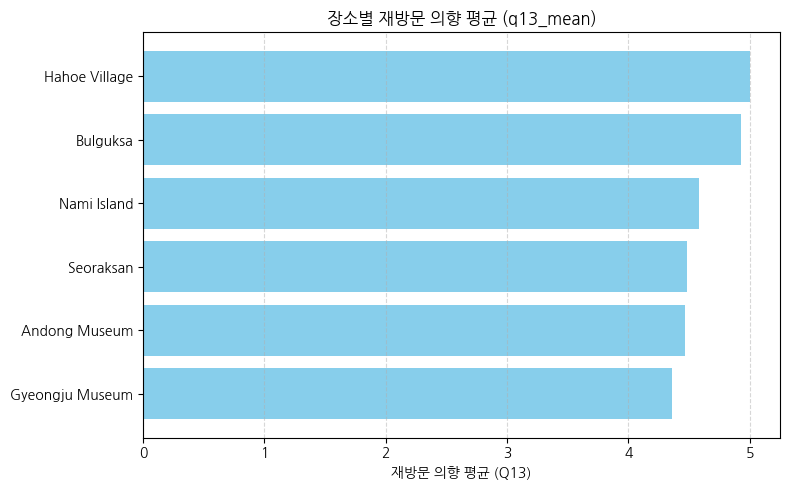

In [ ]:
import matplotlib.pyplot as plt

# 장소별 평균 재방문의향 값 추출
df_q13_place = df_combined[["place", "q13_mean"]].drop_duplicates().sort_values(by="q13_mean", ascending=False)

# 시각화
plt.figure(figsize=(8, 5))
plt.barh(df_q13_place["place"], df_q13_place["q13_mean"], color="skyblue")
plt.xlabel("재방문 의향 평균 (Q13)")
plt.title("장소별 재방문 의향 평균 (q13_mean)")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter
import numpy as np
import matplotlib.colors as mcolors

def plot_network_with_q13(df, activity_type, top_n=80):
    df_type = df[df["type"] == activity_type]

    cooccurrence = []
    word_q13 = []

    for _, row in df_type.iterrows():
        tokens = row["tokens"]
        q13 = row["q13_mean"]  # 또는 "q13_mean"
        if isinstance(tokens, list):
            tokens = list(set(tokens))
            cooccurrence += list(combinations(tokens, 2))
            for word in tokens:
                word_q13.append((word, q13))

    pair_counts = Counter(cooccurrence).most_common(top_n)

    df_word_q13 = pd.DataFrame(word_q13, columns=["word", "q13"])
    word_avg_q13 = df_word_q13.groupby("word")["q13"].mean().to_dict()

    G = nx.Graph()
    for (w1, w2), count in pair_counts:
        G.add_edge(w1, w2, weight=count)

    pos = nx.spring_layout(G, k=0.5, seed=42)
    weights = [d["weight"] for _, _, d in G.edges(data=True)]
    node_colors = [word_avg_q13.get(n, 4.5) for n in G.nodes()]

    # 🎯 명시적으로 fig, ax 객체 생성
    fig, ax = plt.subplots(figsize=(10, 8))

    nx.draw(
        G, pos, ax=ax, with_labels=True, node_size=700, font_size=10,
        edge_color=weights, edge_cmap=plt.cm.Blues, width=2,
        edge_vmin=min(weights), edge_vmax=max(weights),
        node_color=node_colors, cmap=plt.cm.Reds
    )

    # 색상 정보 명확히 연결
    norm = mcolors.Normalize(vmin=min(node_colors), vmax=max(node_colors))
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("평균 q13 (재방문 의향)")

    ax.set_title(f"[{activity_type.upper()}] 키워드 × 재방문 의향 강조")
    plt.tight_layout()
    plt.show()


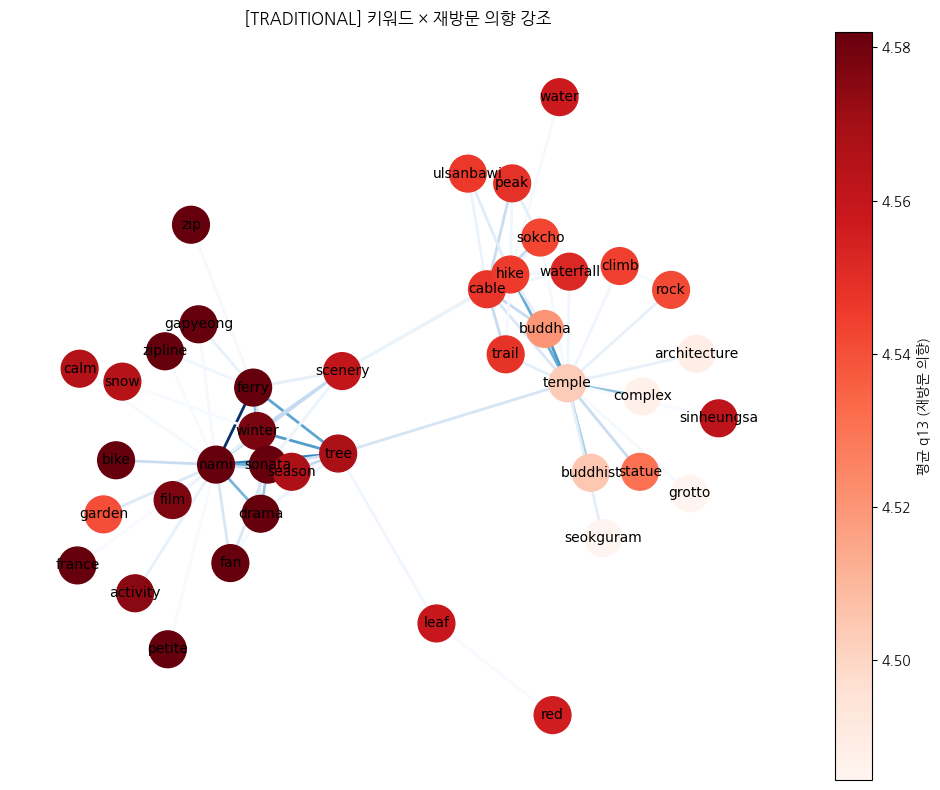

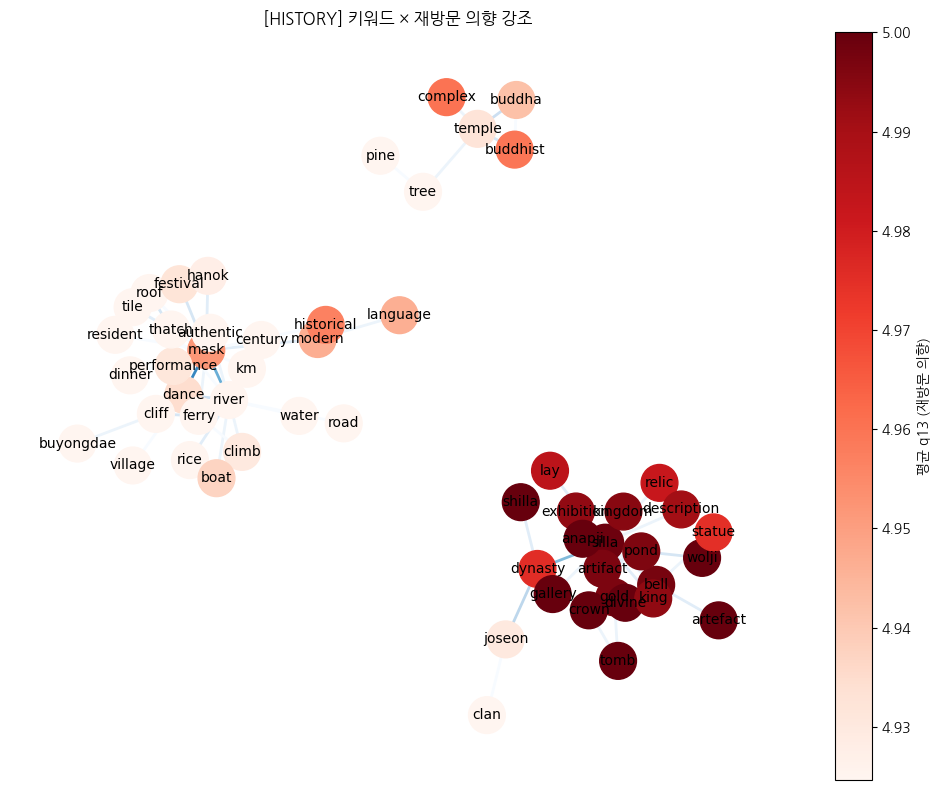

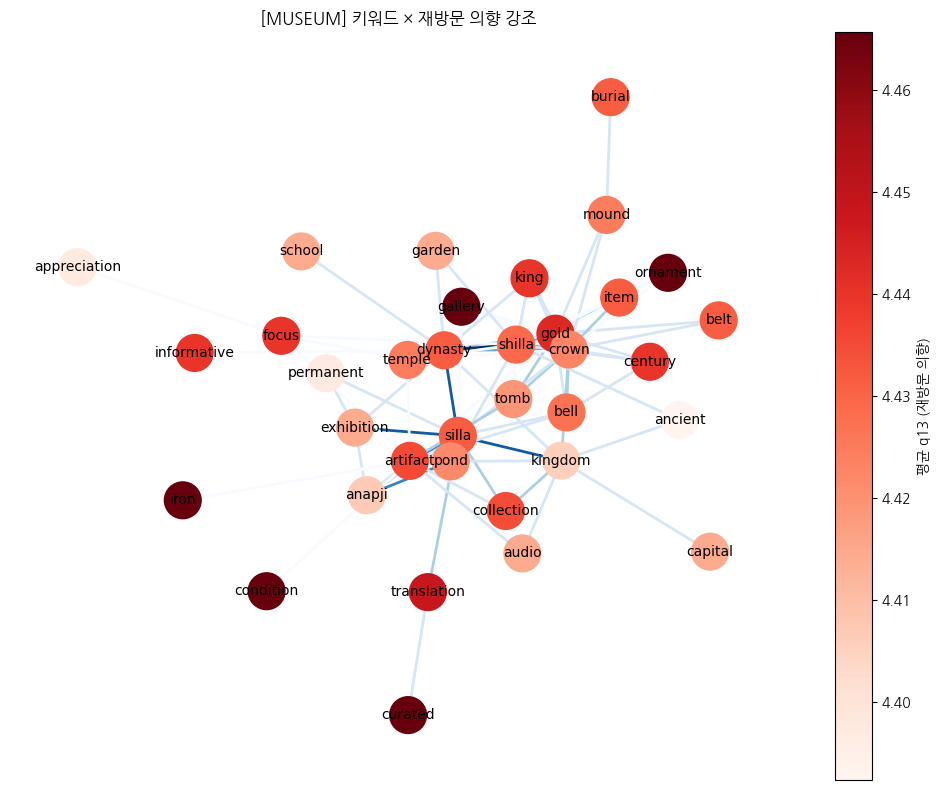

In [ ]:
plot_network_with_q13(df_combined, "traditional")     # 자연경관형
plot_network_with_q13(df_combined, "history")    # 역사문화형
plot_network_with_q13(df_combined, "museum")    # 역사문화형

## 감정 가중치부여 의미연결망

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict
import numpy as np
import matplotlib.colors as mcolors

def plot_sentiment_weighted_network(df, activity_type, top_n=80):
    # 1. 타입 필터링
    df_type = df[df["type"] == activity_type]

    # 2. 감성 가중 단어쌍 누적
    pair_weights = defaultdict(float)
    word_sentiments = defaultdict(list)

    for _, row in df_type.iterrows():
        tokens = row["tokens"]
        sentiment = row["sentiment_score"]
        if isinstance(tokens, list):
            tokens = list(set(tokens))  # 중복 제거
            for pair in combinations(tokens, 2):
                pair_weights[pair] += sentiment  # 감성 가중치 누적
            for word in tokens:
                word_sentiments[word].append(sentiment)

    # 3. 상위 단어쌍
    top_pairs = sorted(pair_weights.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # 4. 단어별 평균 감성 점수
    word_avg_sentiment = {word: np.mean(scores) for word, scores in word_sentiments.items()}

    # 5. 그래프 구성
    G = nx.Graph()
    for (w1, w2), weight in top_pairs:
        G.add_edge(w1, w2, weight=weight)

    pos = nx.spring_layout(G, k=0.5, seed=42)
    edge_weights = [d["weight"] for (_, _, d) in G.edges(data=True)]
    node_colors = [word_avg_sentiment.get(n, 0.0) for n in G.nodes()]

    # 🎨 시각화 with colorbar fix
    fig, ax = plt.subplots(figsize=(10, 8))
    nodes = nx.draw_networkx_nodes(
        G, pos, ax=ax,
        node_color=node_colors,
        cmap=plt.cm.Reds,
        node_size=700
    )
    nx.draw_networkx_edges(
        G, pos, ax=ax,
        edge_color=edge_weights,
        edge_cmap=plt.cm.Blues,
        width=2
    )
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=10)

    # colorbar 설정
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("평균 감성 점수")

    ax.set_title(f"[{activity_type.upper()}] 감성가중 의미연결망", fontsize=14)
    ax.axis("off")
    plt.show()

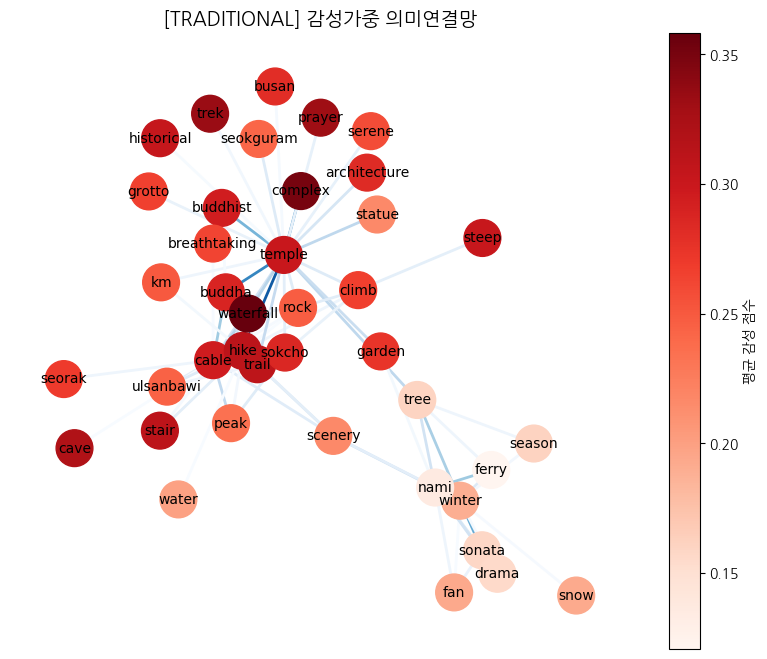

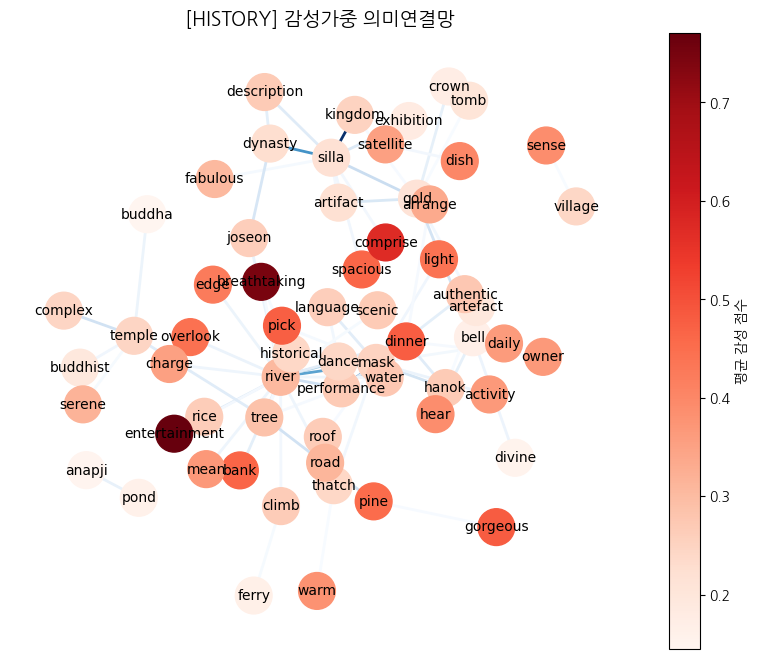

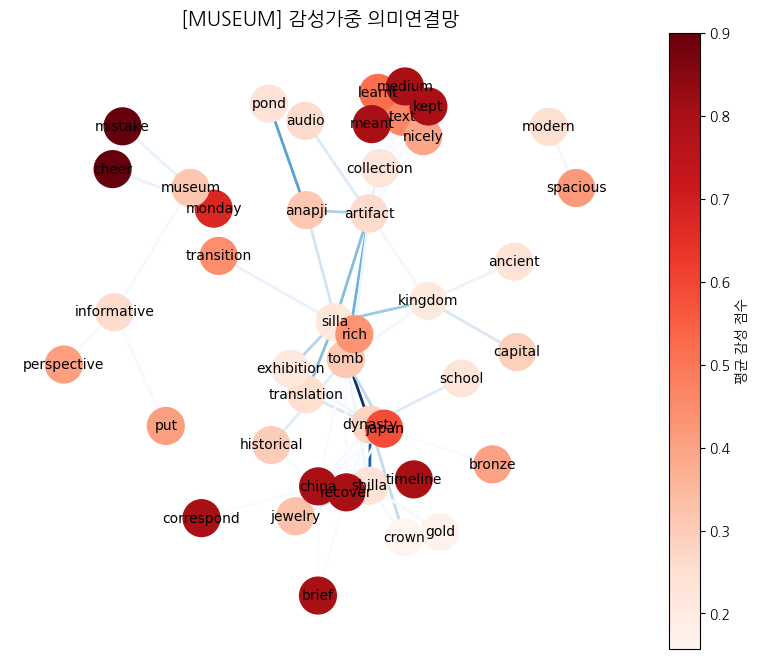

In [ ]:
plot_sentiment_weighted_network(df_combined, "traditional")
plot_sentiment_weighted_network(df_combined, "history")
plot_sentiment_weighted_network(df_combined, "museum")